### Переходим к практике

In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("support/lection2/articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("support/lection2/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [6]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [7]:
with open('support/lection2/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [8]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [9]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-8-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 25.9 s


In [10]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 22s


А теперь в 3 строчки обучим нашу модель

In [11]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [12]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [13]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 34.4 s


In [14]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [15]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(3, 0.17272471), (16, 0.47979033), (19, 0.15370014), (23, 0.17503242)]

In [16]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: военный журнал британский космонавт великобритания который чёрный
topic_1: украина украинский киев кость украинец сон соцсеть
topic_2: год страна это который человек также регион
topic_3: белоруссия nn китай рейтинг место германия россиянин
topic_4: фильм nn мероприятие память стать университет посвятить
topic_5: конкурс супруг употребление белый король миллиардер проба
topic_6: год газ nn суд который дело свой
topic_7: обнаружить тело мозг местный найти человек рейс
topic_8: исследование эксперимент полиция сотрудник расследование задержать выяснить
topic_9: фонд восток сектор писать собирать реконструкция предполагаться
topic_10: погибнуть пострадать высота аэропорт авария произойти экипаж
topic_11: экономика закон законопроект год запрет право поправка
topic_12: пограничный трансляция калифорнийский шоу норвежский судья красноярский
topic_13: напомнить земля температура снизить прогноз градус выделить
topic_14: год который млн тыс банк компания это
topic_15: наука поверхнос

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [17]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [18]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.000000,0.0,0.000000,0.051306,0.0,0.79988,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.038881,0.090694,0.0,0.0,0.011965,0.0
1,4896,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.325909,0.601887,0.0,0.0,0.000000,0.0
2,4897,0.0,0.000000,0.0,0.172731,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.479783,0.000000,0.0,0.153696,0.000000,0.0,0.0,0.175038,0.0
3,4898,0.0,0.000000,0.0,0.117107,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.806579,0.000000,0.0,0.045954,0.000000,0.0,0.0,0.000000,0.0
4,4899,0.0,0.046818,0.0,0.000000,0.000000,0.0,0.21639,0.0,0.0,...,0.0,0.000000,0.301115,0.0,0.000000,0.000000,0.0,0.0,0.271713,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [19]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [20]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [21]:
doc_dict[293622]

array([0.        , 0.        , 0.22488369, 0.        , 0.096974  ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.08126017, 0.        , 0.0226408 , 0.        ,
       0.03739052, 0.18658336, 0.        , 0.082365  , 0.        ,
       0.2401841 , 0.01799953, 0.        , 0.        , 0.        ])

In [22]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [23]:
get_user_embedding(user_articles_list)

array([0.0367535 , 0.        , 0.08542943, 0.01593264, 0.02072141,
       0.        , 0.15384729, 0.02995775, 0.05353173, 0.        ,
       0.        , 0.07432855, 0.00816171, 0.        , 0.05635892,
       0.0206007 , 0.05303252, 0.03040274, 0.03845935, 0.        ,
       0.28707425, 0.        , 0.01485424, 0.00825152, 0.        ])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [24]:
#users['articles'].iloc[33]

In [25]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [26]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.011792,0.035024,0.112070,0.000000,0.081073,0.0,0.154957,0.043405,0.005364,...,0.013037,0.067530,0.005564,0.018242,0.0,0.235672,0.00300,0.006691,0.003295,0.0
1,u108690,0.003189,0.053685,0.124385,0.000000,0.010160,0.0,0.123442,0.040078,0.025188,...,0.009203,0.125031,0.000000,0.033215,0.0,0.312347,0.00195,0.045222,0.005001,0.0
2,u108339,0.019320,0.000000,0.161206,0.003689,0.038186,0.0,0.163344,0.069324,0.067887,...,0.023478,0.010051,0.011393,0.009794,0.0,0.239782,0.00000,0.053292,0.009841,0.0


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [27]:
target = pd.read_csv("support/lection2/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [28]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.011792,0.035024,0.112070,0.000000,0.081073,0.0,0.154957,0.043405,0.005364,...,0.067530,0.005564,0.018242,0.0,0.235672,0.00300,0.006691,0.003295,0.0,0
1,u108690,0.003189,0.053685,0.124385,0.000000,0.010160,0.0,0.123442,0.040078,0.025188,...,0.125031,0.000000,0.033215,0.0,0.312347,0.00195,0.045222,0.005001,0.0,1
2,u108339,0.019320,0.000000,0.161206,0.003689,0.038186,0.0,0.163344,0.069324,0.067887,...,0.010051,0.011393,0.009794,0.0,0.239782,0.00000,0.053292,0.009841,0.0,1


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [30]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [31]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [32]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.15262482, 0.01728714, 0.25310144, 0.25455681, 0.12837857,
       0.11903127, 0.1222002 , 0.1724354 , 0.03461479, 0.11823297])

In [33]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [34]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

mean = {'threshold': thresholds[ix], 'f_score': fscore[ix], 'precision': precision[ix], 'recall': recall[ix]}

Best Threshold=0.238071, F-Score=0.672, Precision=0.628, Recall=0.722


In [35]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1650  105]
 [  69  176]]


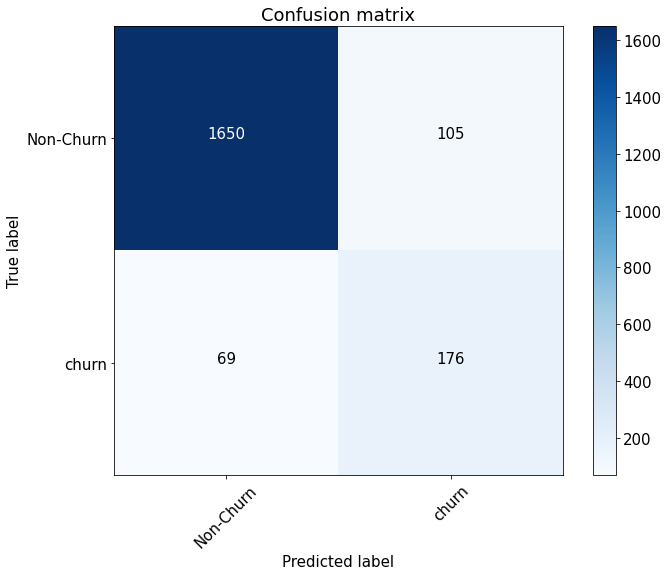

In [36]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [37]:
mean['roc_auc'] = roc_auc_score(y_test, preds)

roc_auc_score(y_test, preds)

0.9441665213093785

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [38]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [39]:
get_user_embedding_median(user_articles_list)

array([0.01176581, 0.        , 0.07120085, 0.        , 0.        ,
       0.        , 0.10037065, 0.01280341, 0.00901719, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01871431,
       0.        , 0.06923735, 0.        , 0.        , 0.        ,
       0.31086093, 0.        , 0.        , 0.        , 0.        ])

In [40]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.000000,0.045058,0.0,0.048487,0.0,0.171373,0.000000,0.000000,...,0.000000,0.023823,0.000000,0.000000,0.0,0.276075,0.0,0.000000,0.0,0.0
1,u108690,0.000000,0.025186,0.132851,0.0,0.000000,0.0,0.099666,0.038824,0.007580,...,0.000000,0.125121,0.000000,0.026463,0.0,0.277486,0.0,0.009052,0.0,0.0
2,u108339,0.007668,0.000000,0.178202,0.0,0.000000,0.0,0.191110,0.031593,0.080176,...,0.013391,0.000000,0.005189,0.006632,0.0,0.255847,0.0,0.013619,0.0,0.0


In [41]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.000000,0.045058,0.0,0.048487,0.0,0.171373,0.000000,0.000000,...,0.023823,0.000000,0.000000,0.0,0.276075,0.0,0.000000,0.0,0.0,0
1,u108690,0.000000,0.025186,0.132851,0.0,0.000000,0.0,0.099666,0.038824,0.007580,...,0.125121,0.000000,0.026463,0.0,0.277486,0.0,0.009052,0.0,0.0,1
2,u108339,0.007668,0.000000,0.178202,0.0,0.000000,0.0,0.191110,0.031593,0.080176,...,0.000000,0.005189,0.006632,0.0,0.255847,0.0,0.013619,0.0,0.0,1


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.17365712, 0.01944335, 0.22511673, 0.23018093, 0.18768967,
       0.11639434, 0.09063576, 0.10715787, 0.0635682 , 0.26672227])

In [43]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
median = {'threshold': thresholds[ix], 'f_score': fscore[ix], 'precision': precision[ix], 'recall': recall[ix]}

Best Threshold=0.275964, F-Score=0.747, Precision=0.787, Recall=0.710


In [44]:
median['roc_auc'] = roc_auc_score(y_test, preds)

roc_auc_score(y_test, preds)

0.9603232746089888

***Использование максимума***

In [45]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector,0)
    return user_vector

get_user_embedding_max(user_articles_list)

array([0.14558336, 0.        , 0.21778971, 0.09559585, 0.12432846,
       0.        , 0.52586651, 0.12172003, 0.27455494, 0.        ,
       0.        , 0.27532291, 0.04897028, 0.        , 0.2124822 ,
       0.1236042 , 0.10241314, 0.16685018, 0.21702528, 0.        ,
       0.54147911, 0.        , 0.08912546, 0.04950915, 0.        ])

In [46]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.058220,0.210141,0.357419,0.000000,0.279749,0.0,0.318840,0.134922,0.032186,...,0.040831,0.186583,0.033382,0.082365,0.0,0.444046,0.018000,0.040144,0.019768,0.0
1,u108690,0.019137,0.160239,0.227606,0.000000,0.037643,0.0,0.350601,0.071973,0.118928,...,0.032509,0.269612,0.000000,0.088163,0.0,0.453165,0.011703,0.151081,0.018671,0.0
2,u108339,0.076078,0.000000,0.262319,0.022132,0.205894,0.0,0.346178,0.203618,0.099332,...,0.080056,0.039230,0.046061,0.027317,0.0,0.327573,0.000000,0.168649,0.045712,0.0


In [47]:
X = pd.merge(user_embeddings, target, 'left')
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)
preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

max_ = {'threshold': thresholds[ix], 'f_score': fscore[ix], 'precision': precision[ix], 'recall': recall[ix]}

Best Threshold=0.399057, F-Score=0.811, Precision=0.835, Recall=0.788


In [48]:
max_['roc_auc'] = roc_auc_score(y_test, preds)

roc_auc_score(y_test, preds)

0.9770591313448457

In [49]:
validate = {'mean': mean, 'median': median, 'max': max_}
validate

{'mean': {'threshold': 0.23807066336815755,
  'f_score': 0.6717267552182163,
  'precision': 0.6276595744680851,
  'recall': 0.7224489795918367,
  'roc_auc': 0.9441665213093785},
 'median': {'threshold': 0.2759636679966952,
  'f_score': 0.7467811158798282,
  'precision': 0.7873303167420814,
  'recall': 0.710204081632653,
  'roc_auc': 0.9603232746089888},
 'max': {'threshold': 0.39905740432203,
  'f_score': 0.8109243697478992,
  'precision': 0.8354978354978355,
  'recall': 0.7877551020408163,
  'roc_auc': 0.9770591313448457}}

In [50]:
pd.DataFrame.from_dict(validate)

,mean,median,max
threshold,0.238071,0.275964,0.399057
f_score,0.671727,0.746781,0.810924
precision,0.627660,0.787330,0.835498
recall,0.722449,0.710204,0.787755
roc_auc,0.944167,0.960323,0.977059


***Вывод:*** сопоставление пользователя и темы с максимальным показателем вероятность, лучше всего влияет на предсказательную способность модели. 